# Scratch pad to write inception v4 network for TinyImageNet project

### various imports

In [1]:
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers import Lambda, concatenate, AveragePooling2D, Add
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import VarianceScaling
from keras.regularizers import l2
from keras.models import Model
from keras import backend as K
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from IPython.display import SVG

Using TensorFlow backend.


### Create the building blocks of the inception network: Conv2D + BN and MaxPooling2D

In [2]:
# Define the convolution layer
def conv2d_bn(x, filter_size, kernel_size, padding_type, activation_type, strides=(1, 1)):
    weight = 5e-4
    x = Conv2D(filters=filter_size, kernel_size=kernel_size, strides=strides, kernel_regularizer=l2(weight),
               kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
               padding=padding_type, activation='linear')(x)
    if activation_type == 'LeakyRelu':
        x = LeakyReLU(alpha=0.3)(x)
    else:
        x = Activation(activation_type)(x)
    x = BatchNormalization(axis=-1)(x)
    return x

# Define the Maxpool Layers
def maxpool_2d(x, pool_size, stride_size, padding_type):
    if stride_size is None:
        stride_size = pool_size
    x = MaxPooling2D(pool_size=(pool_size, pool_size), strides=(stride_size, stride_size), padding=padding_type)(x)
    return x

### Creating the inception STEM block

In [3]:
def inception_stem(x):
    net = conv2d_bn(x, filter_size=64, kernel_size=3, padding_type='same', activation_type='LeakyRelu')
    net = conv2d_bn(net, filter_size=64, kernel_size=3, padding_type='same', activation_type='LeakyRelu')
    net = maxpool_2d(net, pool_size=2, stride_size=2, padding_type='same')            
    return net

### Creating Inception v4- blockA (custom), blockA-reduction (custom)

In [4]:
def inceptionv4_block_A(x):
    branch_0 = conv2d_bn(x, filter_size=64, kernel_size=1, padding_type='same', activation_type='LeakyRelu')
    
    branch_1 = conv2d_bn(x, filter_size=32, kernel_size=1, padding_type='same', activation_type='LeakyRelu')
    branch_1 = conv2d_bn(branch_1, filter_size=64, kernel_size=3, padding_type='same', activation_type='LeakyRelu')
    
    branch_2 = conv2d_bn(x, filter_size=32, kernel_size=1, padding_type='same', activation_type='LeakyRelu')
    branch_2 = conv2d_bn(branch_2, filter_size=64, kernel_size=3, padding_type='same', activation_type='LeakyRelu')
    branch_2 = conv2d_bn(branch_2, filter_size=64, kernel_size=3, padding_type='same', activation_type='LeakyRelu')
    
    branch_3 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    branch_3 = conv2d_bn(branch_3, filter_size=64, kernel_size=1, padding_type='same', activation_type='LeakyRelu')
    
    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=-1)
    return x   

def inceptionv4_blockReduction_A(x):
    branch_0 = conv2d_bn(x, filter_size=256, kernel_size=3, padding_type='same', activation_type='LeakyRelu', strides=(2, 2))
    
    branch_1 = conv2d_bn(x, filter_size=128, kernel_size=1, padding_type='same', activation_type='LeakyRelu')
    branch_1 = conv2d_bn(branch_1, filter_size=192, kernel_size=1, padding_type='same', activation_type='LeakyRelu')
    branch_1 = conv2d_bn(branch_1, filter_size=256, kernel_size=1, padding_type='same', activation_type='LeakyRelu', strides=(2, 2))
    
    branch_2 = maxpool_2d(x, pool_size=3, stride_size=2, padding_type='same')
    
    x = concatenate([branch_0, branch_1, branch_2], axis=-1)
    return x 

### Creating Inception v4- blockB (custom), blockB-reduction (custom)

In [5]:
def inceptionv4_block_B(x):
    branch_0 = conv2d_bn(x, filter_size=384, kernel_size=1, padding_type='same', activation_type='LeakyRelu')
    
    branch_1 = conv2d_bn(x, filter_size=192, kernel_size=1, padding_type='same', activation_type='LeakyRelu')
    branch_1 = conv2d_bn(branch_1, filter_size=224, kernel_size=(1, 7), padding_type='same', activation_type='LeakyRelu')
    branch_1 = conv2d_bn(branch_1, filter_size=256, kernel_size=(7, 1), padding_type='same', activation_type='LeakyRelu')
    
    branch_2 = conv2d_bn(x, filter_size=192, kernel_size=1, padding_type='same', activation_type='LeakyRelu')
    branch_2 = conv2d_bn(branch_2, filter_size=192, kernel_size=(7, 1), padding_type='same', activation_type='LeakyRelu')
    branch_2 = conv2d_bn(branch_2, filter_size=224, kernel_size=(1, 7), padding_type='same', activation_type='LeakyRelu')
    branch_2 = conv2d_bn(branch_2, filter_size=224, kernel_size=(7, 1), padding_type='same', activation_type='LeakyRelu')
    branch_2 = conv2d_bn(branch_2, filter_size=256, kernel_size=(1, 7), padding_type='same', activation_type='LeakyRelu')
    
    branch_3 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    branch_3 = conv2d_bn(branch_3, filter_size=128, kernel_size=1, padding_type='same', activation_type='LeakyRelu')
    
    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=-1)
    return x   

def inceptionv4_blockReduction_B(x):
    branch_0 = conv2d_bn(x, filter_size=192, kernel_size=1, padding_type='same', activation_type='LeakyRelu')
    branch_0 = conv2d_bn(x, filter_size=192, kernel_size=3, padding_type='same', activation_type='LeakyRelu', strides=(2, 2))
    
    branch_1 = conv2d_bn(x, filter_size=192, kernel_size=1, padding_type='same', activation_type='LeakyRelu')
    branch_1 = conv2d_bn(branch_1, filter_size=192, kernel_size=(1, 7), padding_type='same', activation_type='LeakyRelu')
    branch_1 = conv2d_bn(branch_1, filter_size=256, kernel_size=(7, 1), padding_type='same', activation_type='LeakyRelu')
    branch_1 = conv2d_bn(branch_1, filter_size=256, kernel_size=3, padding_type='same', activation_type='LeakyRelu', strides=(2, 2))
    
    branch_2 = maxpool_2d(x, pool_size=3, stride_size=2, padding_type='same')
    
    x = concatenate([branch_0, branch_1, branch_2], axis=-1)
    return x 

### Creating Inception v4- blockC (custom)

In [6]:
def inceptionv4_block_C(x):
    branch_0 = conv2d_bn(x, filter_size=256, kernel_size=1, padding_type='same', activation_type='LeakyRelu')
    
    branch_1 = conv2d_bn(x, filter_size=384, kernel_size=1, padding_type='same', activation_type='LeakyRelu')
    branch_10 = conv2d_bn(branch_1, filter_size=256, kernel_size=(1, 3), padding_type='same', activation_type='LeakyRelu')
    branch_11 = conv2d_bn(branch_1, filter_size=256, kernel_size=(3, 1), padding_type='same', activation_type='LeakyRelu')
    branch1 = concatenate([branch_10, branch_11], axis=-1)    
    
    branch_2 = conv2d_bn(x, filter_size=384, kernel_size=1, padding_type='same', activation_type='LeakyRelu')
    branch_2 = conv2d_bn(branch_2, filter_size=448, kernel_size=(3, 1), padding_type='same', activation_type='LeakyRelu')
    branch_2 = conv2d_bn(branch_2, filter_size=512, kernel_size=(1, 3), padding_type='same', activation_type='LeakyRelu')
    branch_2 = conv2d_bn(branch_2, filter_size=512, kernel_size=(1, 3), padding_type='same', activation_type='LeakyRelu')
    branch_20 = conv2d_bn(branch_2, filter_size=256, kernel_size=(1, 3), padding_type='same', activation_type='LeakyRelu')
    branch_21 = conv2d_bn(branch_2, filter_size=256, kernel_size=(3, 1), padding_type='same', activation_type='LeakyRelu')    
    branch2 = concatenate([branch_20, branch_21], axis=-1)
    
    branch_3 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    branch_3 = conv2d_bn(branch_3, filter_size=256, kernel_size=1, padding_type='same', activation_type='LeakyRelu')
    
    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=-1)
    return x   

In [7]:
def inceptionv4_custom(input_size):    
    input_layer = Input(input_size)
    # stem block of conv2d -> maxpool_2d layers
    net = inception_stem(input_layer)
    
    # call inception block A
    for idx in range(3):        
        net = inceptionv4_block_A(net)
    
    # reduce inception block A
    net = inceptionv4_blockReduction_A(net)
    
    # call inception block B
    for idx in range(3):
        net = inceptionv4_block_B(net)
    
    # reduce inception block B
    net = inceptionv4_blockReduction_B(net)
    
    # call inception block C
    for idx in range(2):
        net = inceptionv4_block_C(net)
    
    # include top
    net = AveragePooling2D(pool_size=(8, 8), padding='valid')(net)
    net = Dropout(0.5)(net)
    net = Flatten()(net)
    net = Dense(units=200, activation='softmax')(net)
    
    # final model
    model = Model(inputs=input_layer, outputs=net)
    return model

In [8]:
input_size = (64, 64, 3)
inception_model = inceptionv4_custom(input_size)

In [9]:
inception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 64)   256         leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
conv2d_2 (

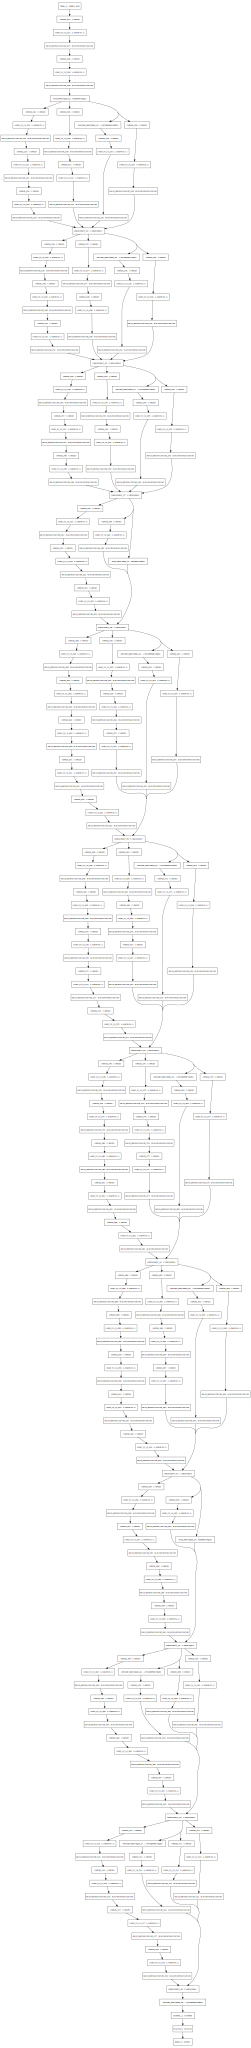

In [45]:
plot_model(inception_model, to_file='C:/Users/PC/Desktop/InceptionV4.png', show_shapes=True, show_layer_names=True)
SVG(model_to_dot(inception_model).create(prog='dot', format='svg'))